# 📊 Experiment: MIL output visualisation and evaluation
**Date:** 2025-04-9  
**Author:** Valentin Oreiller
**Goal:** Test MIL to be used as a filter for tile mining of LUAD tumor tiles

---

## 1. Setup & Imports
## 2. Data Loading
## 3. Preprocessing
## 4. Experiments / Model Training
## 5. Evaluation
## 6. Observations & Next Steps

In [1]:
from pathlib import Path

import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer

from histomil.data.torch_datasets import HDF5WSIDatasetWithTileID, HDF5WSIDataset
from histomil.models.models import load_model, get_device
from histomil.models.mil_models import AttentionAggregatorPL
from histomil.visualization.heatmap import compute_attention_map

In [2]:
wsi_dir = Path("/mnt/nas6/data/CPTAC")

In [3]:
def get_wsi_path(wsi_id, wsi_dir):
    wsi_paths = [f for f in wsi_dir.rglob(wsi_id + ".svs")]
    if len(wsi_paths) > 1:
        raise ValueError(f"Multiple WSI files found for {wsi_id}: {wsi_paths}")
    return wsi_paths[0]

In [4]:
hdf5_path = "/home/valentin/workspaces/histomil/data/processed/embeddings/UNI2_embeddings.h5"

val_dataset = HDF5WSIDatasetWithTileID(hdf5_path, split="test")
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=12,
    collate_fn=HDF5WSIDatasetWithTileID.get_collate_fn_ragged(),
)
test_dataset = HDF5WSIDataset(hdf5_path, split="test")
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=12,
    collate_fn=HDF5WSIDataset.get_collate_fn_ragged(),
)

In [5]:
mil_weights = "/home/valentin/workspaces/histomil/models/mil/UNI2_mil_v1.ckpt"
device = get_device(gpu_id=1)
mil_aggregator = AttentionAggregatorPL.load_from_checkpoint(mil_weights)

INFO:root:Using loss function: BCEWithLogitsLoss with arguments: {}


Using cuda:1


In [6]:
wsi_ids, embeddings, labels, tile_ids = next(iter(val_loader))

In [7]:
labels

tensor([1, 0, 2, 0, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0, 0, 1,
        1, 2, 2, 2, 2, 2, 0, 2])

In [8]:
mil_aggregator.to(device)
mil_aggregator.eval()   

AttentionAggregatorPL(
  (feature_projection): Sequential(
    (0): Linear(in_features=1536, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (attention_tanh): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
  )
  (attention_sigmoid): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (attention_weights): Linear(in_features=128, out_features=1, bias=True)
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=128, out_features=3, bias=True)
  )
  (loss_fn): BCEWithLogitsLoss()
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
)

In [9]:
def plot_attention_map(attention_map, thumbnail):
    # Normalize the attention map between 0 and 1
    attention_norm = (attention_map - attention_map.min()) / (
        attention_map.max() - attention_map.min()
    )

    # Plotting
    plt.figure(figsize=(10, 10))

    # Show WSI thumbnail
    plt.imshow(thumbnail, cmap="gray" if thumbnail.ndim == 2 else None)

    # Overlay attention heatmap with transparency
    plt.imshow(attention_norm, cmap="jet", alpha=0.5)  # alpha adjusts transparency

    plt.axis("off")
    plt.title("WSI Thumbnail with Attention Overlay")
    plt.tight_layout()
    plt.show()

In [14]:
batch_idx = 0
print(f"Batch {batch_idx} with labels {labels[batch_idx]}")

Batch 0 with labels 1


In [15]:
embedding = embeddings[batch_idx].to(device)
pred, proba, attention_scores = mil_aggregator.predict_one_embedding(embedding)

In [16]:
pred

tensor(1, device='cuda:1')

In [17]:
proba

tensor([2.8076e-09, 1.0000e+00, 4.3734e-09], device='cuda:1')

In [18]:
attention_scores = attention_scores.cpu().numpy()

In [19]:
wsi_id = wsi_ids[batch_idx]
wsi_path = get_wsi_path(wsi_id, wsi_dir)
attention_map, thumbnail = compute_attention_map(
    attention_scores,
    tile_ids[batch_idx],
    tile_size=224,
    tile_mpp=1.0,
    wsi_path=wsi_path,
)

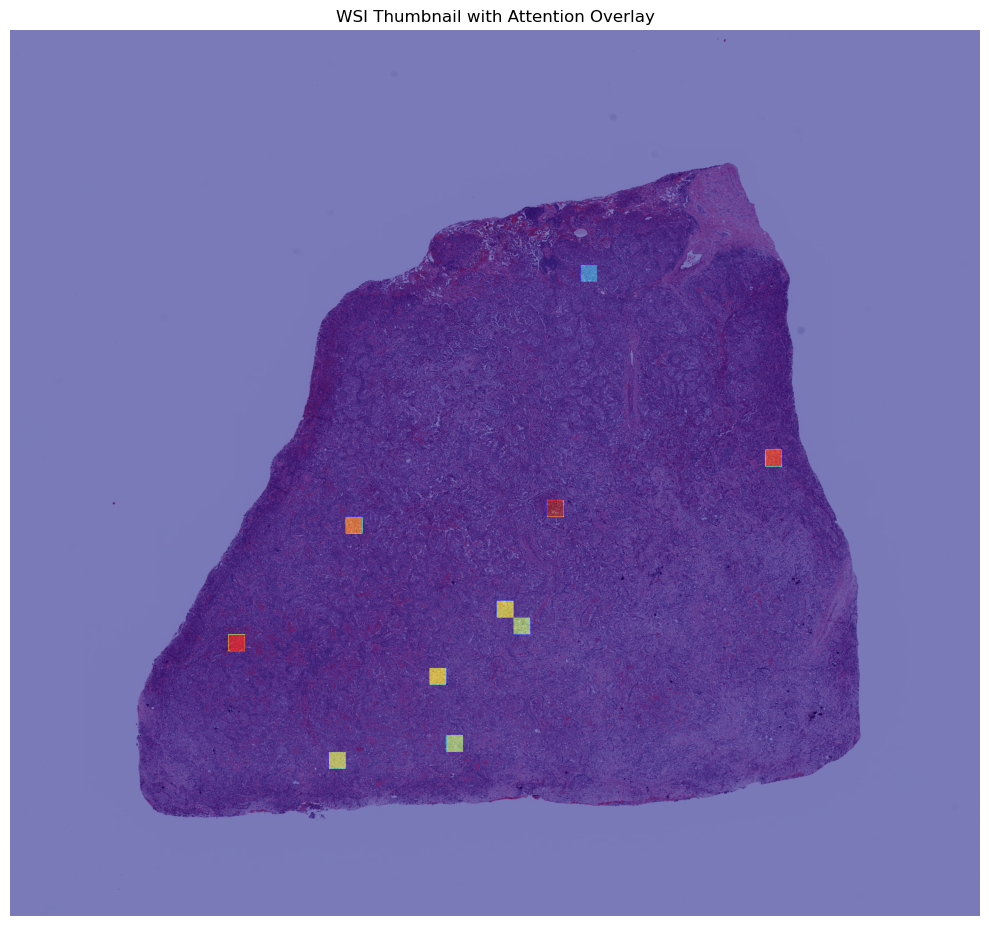

In [20]:
plot_attention_map(np.log(1+attention_map), np.array(thumbnail))

In [ ]:
trainer = Trainer(devices=[1])

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.test(mil_aggregator, test_loader)

In [ ]:

trainer.validate(mil_aggregator, test_loader)